In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Our simulation takes FOREVER to run. Hopefully this will help us figure out the best parameters to run with.  

project.py now has 4 new detector geometries, each with 50m dom spacing, centered on [0,0,0], with 2, 3, 4, or 5 doms along each side of the IceCube (see code below)

I test how varying amounts of shower steps affect run times for each of these geometries. For larger geometries, I test for fewer shower steps because the run time adds up quickly. 

In [2]:
plot_dir = './images/runtime_images/'

num_jobs = 10
num_events = 1

In [3]:
class DOM:
    def __init__(self, location):
        self.location = location
        self.triggered = False
        self.signals = []
        self.times = []
        
    def distance_from(self, location): 
        x = location[0]
        y = location[1]
        z = location[2]
        dom_x = self.location[0]
        dom_y = self.location[1]
        dom_z = self.location[2]
        return np.sqrt((dom_x - x)**2 + (dom_y - y)**2 
                        + (dom_z - z)**2)
    
    def trigger(self, time, num_photons=1): 
        self.triggered = True
        self.signals.append(num_photons)
        self.times.append(time)
        
    def clear_trigger(self):
        self.triggered = False
        self.signals = []
        self.times = []

In [4]:
class detector:
    def __init__(self, dom_list, file_name=None):
        if file_name is not None:
            saved_data = np.load(file_name, 
                                 allow_pickle = True)[()]
            dom_list = []
            for load_dom in saved_data:
                dom_list.append( DOM( load_dom['location'] ) )
                dom_list[-1].triggered = load_dom['trigger']
                dom_list[-1].signals   = load_dom['signals']
                dom_list[-1].times     = load_dom['times']  
                
        self.dom_list = dom_list
        
    def num_triggered(self): 
        num_triggered = 0
        for dom in self.dom_list: #CHANGED
            if dom.triggered: 
                num_triggered += 1
        return num_triggered
    
    def volume(self):
        points = [dom.location for dom in self.dom_list]
        region = ConvexHull(points)
        return region.volume
    
    def save_detector(self, file_name):
        output_array = []
        for DOM in self.dom_list:
            output_array.append({})
            output_array[-1]['location']=DOM.location   
            output_array[-1]['trigger']=DOM.triggered
            output_array[-1]['signals']=DOM.signals
            output_array[-1]['times']=DOM.times
        np.save(file_name, output_array)
        return None

# Runtimes for Based on Detector Size and # of Shower Steps

I use an energy of 4e10 MeV for these tests since the probability of Bremsstrahlung vs Pair Production is roughly 50/50 at this energy

## Runtimes for Random Neutrino locations and directions

In [5]:
# Hard coded information from the log files in 
#     /scratch/abishop/736_project/runtimes-2randwalksteps/vary_detector_showerSteps-FIXED

# All neutrinos simulated are assigned a location and direction at random

runtimes = {
    'IceCube_2': {
        '1 Shower Steps': [  1+( 7/60),  1+( 6/60),    (52/60),    (43/60),    (59/60), 
                               (57/60),  1+(21/60),    (49/60),    (56/60),  1+( 3/60) ],
        '2 Shower Steps': [  4+(27/60),  4+(27/60),  4+(31/60),  3.       ,  3+(14/60),
                             3+(33/60),  3+(39/60),  3+(41/60),  3+(20/60),  4+(24/60) ],
        '3 Shower Steps': [  7+( 5/60),  5+(28/60),  6+(51/60),  7+(24/60),  5+(22/60),
                             8+(18/60), 10+(25/60),  9+(25/60), 10+(31/60),  7+(58/60) ],
        '4 Shower Steps': [ 22+(30/60), 17+(44/60), 16+(18/60), 17+( 9/60), 15+(20/60),
                            24+(41/60), 18+(21/60), 21+(51/60), 23+(12/60), 17+(56/60) ],
        '5 Shower Steps': [ 34+(29/60), 40+(42/60), 34+(47/60), 35+( 1/60), 31+(29/60), 
                            35+(28/60), 40+(56/60), 33+(15/60), 31+(31/60), 40+(59/60)],
    },
    'IceCube_3': {
        '1 Shower Steps': [  3+( 3/60),  2+( 3/60),  3+(10/60),  2+(54/60),  2+( 9/60),
                             1+(48/60),  1+(54/60),  1+(53/60),  1+(53/60),  1+(42/60) ],
        '2 Shower Steps': [  7+(25/60),  7+(46/60),  7+(10/60),  6+(51/60),  7+(34/60),
                             7+(40/60),  7+(27/60),  7+(11/60),  8.       ,  7+(35/60) ],
        '3 Shower Steps': [ 19+( 6/60), 20+(19/60), 18+(57/60), 18+(52/60), 19+(16/60),
                            20+(35/60), 19+(34/60), 14+(54/60), 19+(20/60), 18+(17/60) ],
        '4 Shower Steps': [ 45+(19/60), 43+(52/60), 45.       , 34+(37/60), 33+(46/60),
                            38+( 1/60), 37+(25/60), 36+(55/60), 43+(16/60), 45+(19/60) ],
        '5 Shower Steps': [ 96+( 1/60),103+(48/60), 79+(12/60),104+(48/60),109+(53/60),
                           105+(54/60),107+(27/60),101+(32/60),103+(52/60), 69+(45/60) ],
    },
    'IceCube_4': {
        '1 Shower Steps': [  4+(59/60),  4+(47/60),  6+( 8/60),  5+(58/60),  7+(41/60),
                             4+(55/60),  4+(48/60),  7+(20/60),  5+(19/60),  7+( 1/60) ],
        '2 Shower Steps': [ 28.       , 20+(56/60), 27+( 6/60), 28+(27/60), 27+(17/60),
                            22+( 5/60), 15+(37/60), 20+( 3/60), 19+(39/60), 22+( 2/60) ],
        '3 Shower Steps': [ 41+(44/60), 51+(16/60), 51+( 1/60), 51+(18/60), 50+( 7/60),
                            60+(18/60), 42+(19/60), 52+(12/60), 46+(18/60), 51+(19/60) ],
        '4 Shower Steps': [ 96+( 1/60),103+(48/60), 79+(12/60),104+(48/60),109+(53/60),
                           105+(54/60),107+(27/60),101+(32/60),103+(52/60), 69+(45/60)],
    },
    'IceCube_5': {
        '1 Shower Steps': [  9+(51/60), 10+(22/60), 13+(10/60),  8+(31/60), 10+( 3/60),
                             9+( 8/60),  9+(34/60), 10+(10/60),  9+( 9/60),  8+(30/60) ],
        '2 Shower Steps': [ 38+(18/60), 32+(32/60), 35+(11/60), 35+(44/60), 37+(34/60),
                            30+( 5/60), 37+( 4/60), 29+(21/60), 35+(51/60), 34+(54/60) ],
        '3 Shower Steps': [ 69+(47/60),111+(44/60),103.       , 96.       , 92.       ,
                            73+(33/60), 88+(54/60), 80+(39/60), 79+( 4/60), 87+( 2/60) ],
    },
    
}

In [6]:
runtimes_mean = {}
runtimes_std  = {}

for detector_name, runtime in runtimes.items():
    runtimes_mean[detector_name] = {}
    runtimes_std[detector_name]  = {}
    for shower_steps, data in runtime.items():
        runtimes_mean[detector_name][shower_steps] = np.mean(data)
        runtimes_std[detector_name][shower_steps] = np.std(data)

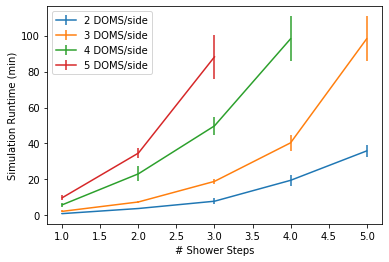

In [7]:
# Plots by shower steps
fig, ax = plt.subplots()
for detector_name, runtime in runtimes_mean.items():
    xs = [int(key[0]) for key in runtime.keys()]
    ys = list(runtime.values())
    yerrs = list(runtimes_std[detector_name].values())
    ax.errorbar(xs, ys, yerrs, label = detector_name[-1] + " DOMS/side")
ax.set_xlabel("# Shower Steps")
ax.set_ylabel("Simulation Runtime (min)")
plt.legend()
plt.savefig(f"{plot_dir}runtime_by_shower_step_RANDOM", dpi=300)
plt.show()

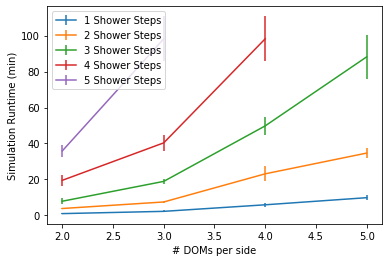

In [8]:
# Plots by # Doms / side
fig, ax = plt.subplots()
for shower_step in runtimes['IceCube_2'].keys():
    xs = []
    if shower_step[0] == '5':
        xs = [2,3]
    elif shower_step[0] == '4':
        xs = [2,3,4]
    else:
        xs = [2,3,4,5]
    ys =   [runtimes_mean[f"IceCube_{x}"][shower_step] for x in xs]
    yerrs = [runtimes_std[f"IceCube_{x}"][shower_step] for x in xs]

    ax.errorbar(xs, ys, yerrs, label = shower_step)
ax.set_xlabel("# DOMs per side")
ax.set_ylabel("Simulation Runtime (min)")
plt.legend()
plt.savefig(f"{plot_dir}runtime_by_detector_RANDOM", dpi=300)
plt.show()

In [9]:
pd.DataFrame(runtimes_mean)

,IceCube_2,IceCube_3,IceCube_4,IceCube_5
1 Shower Steps,0.988333,2.248333,5.893333,9.846667
2 Shower Steps,3.826667,7.465000,23.120000,34.656667
3 Shower Steps,7.878333,18.916667,49.786667,88.171667
4 Shower Steps,19.503333,40.350000,98.220000,NaN
5 Shower Steps,35.861667,98.220000,NaN,NaN


## Runtimes for a fixed Neutrino Event

In [10]:
# Hard coded information from the log files in 
#     /scratch/abishop/736_project/runtimes-2randwalksteps/vary_detector_showerSteps-FIXED

# All neutrinos are traveling in the +y direction and located above the origin and 15m in 
#     the y and z direction from the nearest DOM (hence why 3x3x3 and 5x5x5 are at 0,-35,-35)

runtimes = {
    'IceCube_2': {
        # Neutrino at 0, -10, 10
        '1 Shower Steps': [    (42/60),    (48/60),    (41/60),    (41/60),    (41/60),
                               (49/60),    (39/60),    (43/60),    (42/60),    (44/60) ],
        '2 Shower Steps': [  2+(36/60),  3+(34/60),  2+(48/60),  3+( 3/60),  3+(48/60),
                             3+(12/60),  4+(35/60),  3+( 4/60),  3+(42/60),  3+( 4/60) ],
        '3 Shower Steps': [  7+(38/60),  9+(51/60),  6.       ,  5+(59/60),  5+(58/60),
                             7+(41/60),  7+(35/60),  6+(21/60),  7+(38/60),  7+(54/60) ],
        '4 Shower Steps': [ 17+(24/60), 16+(31/60), 16+(39/60), 16+(37/60), 17+(48/60),
                            15+(18/60), 16+( 1/60), 19+(30/60), 15+(51/60), 16+( 1/60) ],
        '5 Shower Steps': [ 31+(53/60), 25+(20/60), 25+(55/60), 28+(44/60), 29+(30/60),
                            37+(48/60), 40+(14/60), 29+(12/60), 40+(20/60), 29+(23/60) ],
    },
    'IceCube_3': {
        # Neutrino at 0, -35, 35
        '1 Shower Steps': [  2+(44/60),  2+(34/60),  2+(55/60),  2+(56/60),  2+(49/60),
                             2+(31/60),  2+(30/60),  2+(51/60),  3+( 2/60),  2+(16/60)],
        '2 Shower Steps': [  8+(22/60),  9+(20/60),  9+( 4/60), 11+(31/60), 11+(24/60),
                            11+(18/60),  8+(23/60),  9+( 5/60), 11+(50/60), 12+( 4/60) ],
        '3 Shower Steps': [ 19+(18/60), 26+( 4/60), 19+(17/60), 27+(15/60), 26+(53/50),
                            25+(13/60), 26+(14/60), 25+(16/60), 21+(46/60), 21+( 5/60) ],
        '4 Shower Steps': [ 37+(18/60), 47+(17/60), 34+(39/60), 38.       , 47+(50/60),
                            48+(17/60), 57+(27/60), 37+(43/60), 45+( 1/60), 38+(27/60) ],
        '5 Shower Steps': [ 85+(31/60), 85+(12/60), 82+(22/60),110+(13/60),105+(48/60),
                           120+(39/60),112.       , 82+(36/90), 78+(23/60), 80+(13/60) ],
        # Neutrino at 0, -10, 10
#         '1 Shower Steps': [  2.       ,  1+(57/60),  2+( 5/60),  2+( 5/60),  2+(31/60),
#                              2+(42/60),  1+(54/60),  1+(56/60),  1+(55/60),  1+(48/60) ],
#         '2 Shower Steps': [  7+(13/60), 10+(48/60), 11+(45/60), 10+(44/60), 10+(26/60),
#                             10+(30/60),  7+(36/60),  7+(47/60),  8+(21/60),  8+(21/60) ],
#         '3 Shower Steps': [ 16+(49/60), 19+(30/60), 19+(27/60), 19+(28/60), 19+(24/60),
#                             17+(33/60), 21+(23/60), 17+(29/60), 22+(32/60), 16+(49/60) ],
#         '4 Shower Steps': [ 46+(27/60), 33+(41/60), 33+(52/60), 38+(27/60), 54+(18/60),
#                             56+(48/60), 54+(48/60), 55+(11/60), 31+(38/60), 40+(19/60) ],
#         '5 Shower Steps': [ 93+( 8/60),111+(24/60),142+( 6/60),117+(12/60),117+(32/60),
#                             88+(33/60), 79+(21/60), 83+( 2/60), 79+(49/60),107+(20/60) ],
    },
    'IceCube_4': {
        # Neutrino at 0, -10, 10
        '1 Shower Steps': [  5+(22/60),  5+(30/60),  6+(53/60),  7+(15/60),  7+( 8/60),
                             5+(41/60),  5+(27/60),  4+(13/60),  5+(28/60),  4+(17/60) ],
        '2 Shower Steps': [ 28+(45/60), 16+(42/60), 16+(11/60), 19.       , 18+(57/60),
                            18+( 3/60), 24+(46/60), 16+(28/60), 17+( 5/60), 14+(18/60) ],
        '3 Shower Steps': [ 56+(39/60), 39+(30/60), 42+(46/60), 33+(53/60), 39+(33/60),
                            39+(20/60), 56+( 9/60), 56+(16/60), 44+(54/60), 51+(19/50) ],
        '4 Shower Steps': [110+(43/60),113+(24/60),111+(10/60),107+( 7/60),106+( 4/60),
                            96+(39/60),114+(58/60), 82+( 9/60),106+(58/60), 99+(21/60) ],
    },
    'IceCube_5': {
        # Neutrino at 0, -35, 35
        '1 Shower Steps': [ 13+(50/60),  9+(50/60), 10+(34/60), 10+(16/60), 11+( 2/60),
                            11+(46/60), 12+(16/60), 13+( 3/60), 10+(14/60) ],
        '2 Shower Steps': [ 34+(50/60), 46+(36/60), 41+(34/60), 55+(36/60), 37+(13/60),
                            47+( 7/60), 39+(58/60), 36+(51/60), 68+(20/60), 37+(19/60) ],
        '3 Shower Steps': [ 72+(37/60), 73+(46/60), 59+( 3/60), 77+(46/60), 85+(58/60),
                           106+(22/60), 97+(56/60), 85+(56/60), 75+(55/60), 67+(17/60) ],
        # Neutrino at 0, -10, 10
#         '1 Shower Steps': [  8+(33/60),  8+(22/60), 10+(25/60),  7+(50/60),  7+(46/60),
#                             10+(12/60), 10+( 3/60),  8+(10/60),  8+(12/60),  8+(14/60)],
#         '2 Shower Steps': [ 39+(15/60), 45+(53/60), 29+( 2/60), 28+(55/60), 38+(36/60),
#                             39+(55/60), 45+(15/60), 51+ (4/60), 42+(57/60), 33+(39/60) ],
#         '3 Shower Steps': [ 97+(30/60), 96+(49/60), 94+(34/60), 71+(37/60), 65+(52/60),
#                             92+(29/60), 70+(35/60), 69+(11/60),132+(43/60),110+(39/60) ],
    },
    
}

In [11]:
runtimes_mean = {}
runtimes_std  = {}

for detector_name, runtime in runtimes.items():
    runtimes_mean[detector_name] = {}
    runtimes_std[detector_name]  = {}
    for shower_steps, data in runtime.items():
        runtimes_mean[detector_name][shower_steps] = np.mean(data)
        runtimes_std[detector_name][shower_steps] = np.std(data)

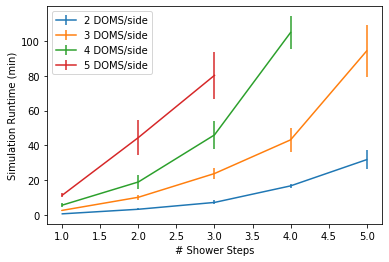

In [12]:
# Plots by shower steps
fig, ax = plt.subplots()
for detector_name, runtime in runtimes_mean.items():
    xs = [int(key[0]) for key in runtime.keys()]
    ys = list(runtime.values())
    yerrs = list(runtimes_std[detector_name].values())
    ax.errorbar(xs, ys, yerrs, label = detector_name[-1] + " DOMS/side")
ax.set_xlabel("# Shower Steps")
ax.set_ylabel("Simulation Runtime (min)")
plt.legend()
plt.savefig(f"{plot_dir}runtime_by_shower_step_FIXED", dpi=300)
plt.show()

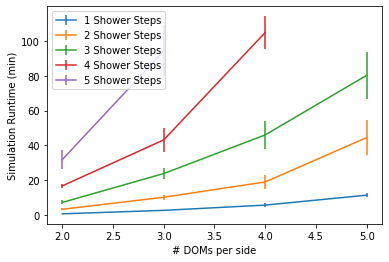

In [13]:
# Plots by # Doms / side
fig, ax = plt.subplots()
for shower_step in runtimes['IceCube_2'].keys():
    xs = []
    if shower_step[0] == '5':
        xs = [2,3]
    elif shower_step[0] == '4':
        xs = [2,3,4]
    else:
        xs = [2,3,4,5]
    ys =   [runtimes_mean[f"IceCube_{x}"][shower_step] for x in xs]
    yerrs = [runtimes_std[f"IceCube_{x}"][shower_step] for x in xs]

    ax.errorbar(xs, ys, yerrs, label = shower_step)
ax.set_xlabel("# DOMs per side")
ax.set_ylabel("Simulation Runtime (min)")
plt.legend()
plt.savefig(f"{plot_dir}runtime_by_detector_FIXED", dpi=300)
plt.show()

In [14]:
pd.DataFrame(runtimes_mean)

,IceCube_2,IceCube_3,IceCube_4,IceCube_5
1 Shower Steps,0.716667,2.713333,5.723333,11.427778
2 Shower Steps,3.343333,10.235000,19.025000,44.540000
3 Shower Steps,7.258333,23.852667,46.038000,80.260000
4 Shower Steps,16.766667,43.198333,104.855000,NaN
5 Shower Steps,31.831667,94.275000,NaN,NaN


## Conclusion

The duration of the simulation increased roughly linearly with number of DOMS, so cubicly when increasing the number of DOMs on each side of our IceCube. 

The duration of the simulation increased roughly 2.5 times for each additional shower step.

Simulations were performed on fixed points to remove the chance of neutrinos being randomly generated away from the detector and speeding up the simulation. The 10 random tests still provided informative data though.

At one point the number of random walk steps was tested and little impact was seen, likely because absorbtion by ice and DOM can stop photons from taking so many random walk steps to have a large impact

# Runtime by Energy

In [15]:
# for IceCube 4 and 3 shower steps
runtimes = {
    '1e6':  [ 40+(34/60), 62+(46/60), 63+(18/60), 62+(13/60), 57+(53/60),
              54+(45/60), 57+(28/60), 36+( 3/60), 33+(47/60), 57+(58/60) ],
    '1e8':  [ 54+( 7/60), 37+( 9/60), 33+(14/60), 49+(17/60), 50+( 8/60),
              45+(57/60), 49+(43/60), 56+(17/60), 48+(39/60), 48+(32/60) ],
    '4e10': [ 56+(39/60), 39+(30/60), 42+(46/60), 33+(53/60), 39+(33/60),
              39+(20/60), 56+( 9/60), 56+(16/60), 44+(54/60), 51+(19/50) ],
    '1e12': [ 56+( 1/60), 49+(30/60), 47+(29/60), 45+(33/60), 32+(43/60),
              45+(27/60), 48+(52/60), 43+(58/60), 51+(24/60), 50+(25/60) ],
    '1e14': [ 52+(54/60), 51+(10/60), 52+(11/60), 56+(47/60), 52+(56/60),
              43+(32/60), 55+(57/60), 36+(38/60), 55+(35/60), 50+(16/60) ],
}

In [16]:
runtimes_mean = {}
runtimes_std  = {}

for energy, runtime in runtimes.items():
    runtimes_mean[energy] = np.mean(runtime)
    runtimes_std[energy]  = np.std(runtime)

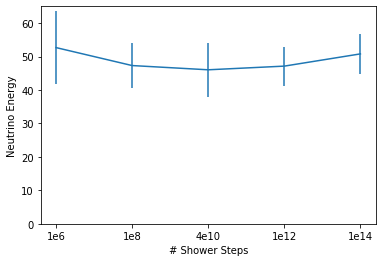

In [17]:
# Plots by shower steps
fig, ax = plt.subplots()
xs = list(runtimes_mean.keys())
ys = list(runtimes_mean.values())
yerrs = list(runtimes_std.values())
ax.errorbar(xs, ys, yerrs)
ax.set_xlabel("# Shower Steps")
ax.set_ylabel("Neutrino Energy")
ax.set_ylim(0,65)
plt.show()

In [18]:
runtimes_mean

{'1e6': 52.675,
 '1e8': 47.30499999999999,
 '4e10': 46.038,
 '1e12': 47.13666666666667,
 '1e14': 50.79333333333334}

## Conclusion

The energy of the shower has little impact on the runtime. 

# Number of DOMs Triggered for Various Detectors and # Shower Steps

We would love to run a 2x2x2 detector with just one shower step since it takes the least amount of time, but it may not simulate the shower well. We run these simulations to analyze how far the shower is able to propagate and how many DOMs trigger for each setting analyzed for run time to help us pick the best tradeoff for accuracy vs runtime

In [19]:
data_dir = "/data/user/abishop/736_project/runtimes-2randwalksteps/vary_detector_showerSteps-FIXED/"

In [20]:
triggers = {
    'IceCube_2': {
        '1 Shower Steps': [],
        '2 Shower Steps': [],
        '3 Shower Steps': [],
        '4 Shower Steps': [],
        '5 Shower Steps': [],
    },
    'IceCube_3': {
        '1 Shower Steps': [],
        '2 Shower Steps': [],
        '3 Shower Steps': [],
        '4 Shower Steps': [],
        '5 Shower Steps': [],
    },
    'IceCube_4': {
        '1 Shower Steps': [],
        '2 Shower Steps': [],
        '3 Shower Steps': [],
        '4 Shower Steps': [],
    },
    'IceCube_5': {
        '1 Shower Steps': [],
        '2 Shower Steps': [],
        '3 Shower Steps': [],
    },
    
}


for detector_side in [2, 3, 4, 5]:
    for shower_step in [1,2,3,4,5]:
        for j in range(num_jobs):
            file_name = (f"/data/user/abishop/736_project/runtimes-2randwalksteps/"
                         f"vary_detector_showerSteps-FIXED/runtime-i{detector_side}"
                         f"-s{shower_step}-c10-e4e10"
                         f"-{j}-detector.npy")
            
            try:
            
                event_data = {'doms':[], 'file name': file_name}

                IceCube = detector([], file_name)
                triggers[f"IceCube_{detector_side}"][f"{shower_step} Shower Steps"].append(
                    IceCube.num_triggered() )
            
            except FileNotFoundError:
                continue
                
pd.DataFrame(triggers)

,IceCube_2,IceCube_3,IceCube_4,IceCube_5
1 Shower Steps,"[1, 2, 1, 2, 1, 2, 1, 2, 2, 1]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[1, 1, 2, 2, 1, 1, 2, 2, 1, 1]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
2 Shower Steps,"[2, 1, 2, 2, 2, 2, 1, 2, 2, 2]","[2, 2, 3, 3, 2, 2, 3, 2, 4, 4]","[2, 2, 2, 2, 2, 1, 2, 2, 2, 2]","[4, 3, 3, 2, 2, 2, 3, 3, 3, 2]"
3 Shower Steps,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2, 3, 2, 4, 4, 2, 2, 4, 3, 3]","[3, 3, 3, 3, 4, 2, 3, 4, 1, 3]","[3, 3, 3, 4, 3, 4, 5, 5, 4, 4]"
4 Shower Steps,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[3, 4, 4, 2, 2, 2, 4, 2, 2, 3]","[6, 4, 5, 4, 4, 5, 5, 4, 5, 5]",NaN
5 Shower Steps,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[4, 3, 4, 2, 3, 4, 4, 3, 3, 3]",NaN,NaN


In [21]:
triggers_mean = {}
triggers_std  = {}

for detector_name, trigger in triggers.items():
    triggers_mean[detector_name] = {}
    triggers_std[detector_name]  = {}
    for shower_steps, data in trigger.items():
        triggers_mean[detector_name][shower_steps] = np.mean(data)
        triggers_std[detector_name][shower_steps]  = np.std(data)
    
pd.DataFrame(triggers_mean)

,IceCube_2,IceCube_3,IceCube_4,IceCube_5
1 Shower Steps,1.5,2.0,1.4,2.0
2 Shower Steps,1.8,2.7,1.9,2.7
3 Shower Steps,2.0,2.9,2.9,3.8
4 Shower Steps,2.0,2.8,4.7,NaN
5 Shower Steps,2.0,3.3,NaN,NaN


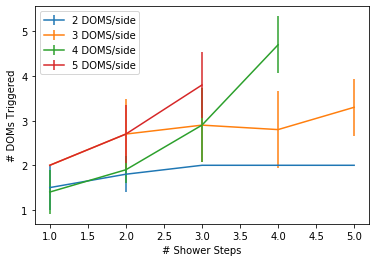

In [22]:
# Plots by shower steps
fig, ax = plt.subplots()
for detector_name, trigger in triggers_mean.items():
    xs = [int(key[0]) for key in trigger.keys()]
    ys = list(trigger.values())
    yerrs = list(triggers_std[detector_name].values())
    ax.errorbar(xs, ys, yerrs, label = detector_name[-1] + " DOMS/side")
ax.set_xlabel("# Shower Steps")
ax.set_ylabel("# DOMs Triggered")
plt.legend()
plt.savefig(f"{plot_dir}dom_triggering_by_shower_steps", dpi=300)
plt.show()

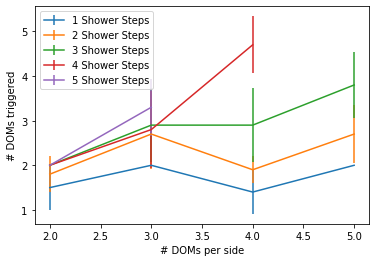

In [23]:
# Plots by # Doms / side
fig, ax = plt.subplots()
for shower_step in triggers['IceCube_2'].keys():
    xs = []
    if shower_step[0] == '5':
        xs = [2,3]
    elif shower_step[0] == '4':
        xs = [2,3,4]
    else:
        xs = [2,3,4,5]
    ys =   [triggers_mean[f"IceCube_{x}"][shower_step] for x in xs]
    yerrs = [triggers_std[f"IceCube_{x}"][shower_step] for x in xs]

    ax.errorbar(xs, ys, yerrs, label = shower_step)
ax.set_xlabel("# DOMs per side")
ax.set_ylabel("# DOMs triggered")
plt.legend()
plt.savefig(f"{plot_dir}dom_triggering_by_detector", dpi=300)
plt.show()